In [2]:
import rioxarray
import xarray as xr
import numpy as np
from richardutils import tif_dict
import os
from rasterio.enums import Resampling
from richardutils import tif_dict, makegdf, df_bb, rasterize_one
from rioxarray.merge import merge_arrays

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial, rasterize_image

from shapely.geometry import box, mapping
from functools import partial
import json


## Data
### National-Scale Geophysical, Geologic, and Mineral Resource Data and Grids for the United States, Canada, and Australia: Data in Support of the Tri-National Critical Minerals Mapping Initiative
https://www.sciencebase.gov/catalog/item/6193e9f3d34eb622f68f13a5

In [3]:
usgs = tif_dict(r'D:\Geophysics')

In [4]:
for tif in usgs:
    print(tif, usgs[tif].rio.resolution(),usgs[tif].rio.bounds(),usgs[tif].squeeze().shape)

GeophysicsGravity_HGM_AusCan.tif (0.031, -0.031) (-168.1285, -43.6635, 159.1075, 83.12650000000001) (4090, 10556)
GeophysicsGravity_Australia.tif (0.00553, -0.00553) (112.919835, -43.65658499999999, 159.100865, -9.221274999999999) (6227, 8351)
GeophysicsGravity_HGM_Australia.tif (0.00553, -0.00553) (112.919835, -43.65658499999999, 159.100865, -9.221274999999999) (6227, 8351)
GeophysicsGravity_UpCont30km_Australia.tif (0.00553, -0.00553) (112.919835, -43.65658499999999, 159.100865, -9.221274999999999) (6227, 8351)
GeophysicsGravity_UpCont30km_HGM_Australia.tif (0.00553, -0.00553) (112.919835, -43.65658499999999, 159.100865, -9.221274999999999) (6227, 8351)
GeophysicsSatelliteGravity_ShapeIndex_Australia.tif (0.2, -0.2) (113.0, -43.60000000000001, 153.6, -10.600000000000001) (165, 203)
GeophysicsSatelliteGravity_ShapeIndex_USCanada.tif (0.2, -0.2) (-178.2, 21.800000000000004, -52.59999999999999, 83.2) (307, 628)
GeophysicsGravity_HGM_USCanada.tif (0.031, -0.031) (-168.1285, 23.5755000000

In [5]:
upscale_factor = usgs['GeophysicsGravity_HGM_USCanada.tif'].rio.resolution()[0]/usgs['GeophysicsGravity_HGM_Australia.tif'].rio.resolution()[0]
print(upscale_factor)
new_width = usgs['GeophysicsGravity_HGM_Australia.tif'].rio.width / upscale_factor
new_height = usgs['GeophysicsGravity_HGM_Australia.tif'].rio.height / upscale_factor
print(new_width, new_height)


aus_downsampled = usgs['GeophysicsGravity_HGM_Australia.tif'].rio.reproject(
    usgs['GeophysicsGravity_HGM_Australia.tif'].rio.crs,
    shape=(int(new_height)+1, int(new_width)+1),
    resampling=Resampling.bilinear,
)


5.605786618444846
1489.7106451612906 1110.8164516129034


In [6]:
aus_downsampled

<xarray.DataArray (band: 1, y: 1111, x: 1490)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 112.9 113.0 113.0 113.0 ... 159.0 159.0 159.1 159.1
  * y            (y) float64 -9.237 -9.268 -9.299 -9.33 ... -43.58 -43.61 -43.64
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  5.856919861077052e-05
    STATISTICS_MAXIMUM:      0.1543258279562
    STATISTICS_MEAN:         0.0087725620798214
    STATISTICS_MINIMUM:      8.7451635408797e-06
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0.0076530515881425
    scale_factor:            1.0
    add_offset:              0.0

In [8]:
aus_downsampled.rio.resolution()

(0.030993979865771817, -0.030994878487848782)

In [9]:
usgs['GeophysicsGravity_HGM_USCanada.tif'].rio.resolution()

(0.031, -0.031)

In [10]:
from osgeo import gdal, osr

In [11]:
gravdir = r'D:\Geophysics\_GeophysicalDatGravAus'
source_ds = gdal.Open(gravdir + "\\" + 'GeophysicsGravity_HGM_Australia.tif')

gravdir = r'D:\\Geophysics\_GeophysicalDatGrav'

# Open the target raster to get its geotransform and spatial reference
target_ds = gdal.Open(gravdir + "\\" + 'GeophysicsGravity_HGM_USCanada.tif')
target_geo_transform = target_ds.GetGeoTransform()
target_spatial_ref = target_ds.GetSpatialRef()

# Create a new dataset for the reprojected raster
reproj_ds = gdal.Warp('reprojected.tif', source_ds,
                      format='GTiff',
                      xRes=target_geo_transform[1],
                      yRes=target_geo_transform[5],
                      dstSRS=target_spatial_ref)

# Close the datasets
source_ds = None
target_ds = None
reproj_ds = None

reproj = rioxarray.open_rasterio('reprojected.tif')
reproj.rio.resolution()

(0.031, -0.031)

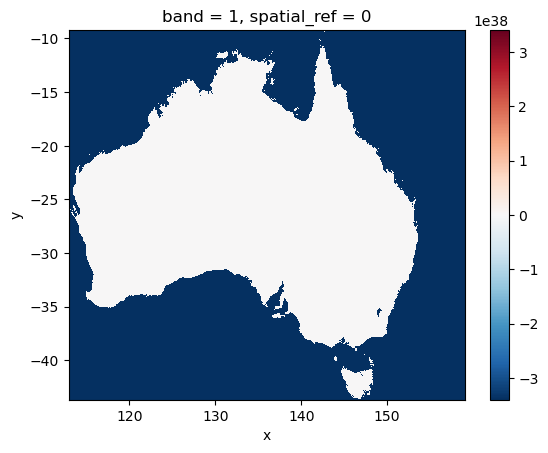

In [12]:
reproj.plot(rob)